In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import spearmanr
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import quilt3

from fish_morphology_code.analysis.notebook_utils import (
    DAY_18_COLOR,
    DAY_32_COLOR,
    DAY_COLOR_PALETTE,
    DAY_COLOR_PALETTE_THREE,
    BAR_PLOT_COLUMNS,
    SHORT_FEAT_NAME_MAP,
    BAR_PLOT_COLUMNS_SHORT,
    PROBE_ORDER,
    CI_EXTENT,
    FEATURE_TYPE_MAP,
    safe,
    get_regression_coef,
    boot_regression,
    ci_low,
    ci_high,
    make_reg_plot_ci_df,
    make_regression_bar_plot,
    get_pred_true,
    make_regression_scatter_plot,
    boot_spearmanr,
)

In [2]:
SAVE=True

if SAVE:
    SAVE_DIR = Path("./plots_anova")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    save_dir_pngs = SAVE_DIR/"pngs"
    save_dir_svgs = SAVE_DIR/"svgs"
    save_dir_pngs.mkdir(parents=True, exist_ok=True)
    save_dir_svgs.mkdir(parents=True, exist_ok=True)

## Load FISH data

## first two rounds
This takes a few minutes becuase it has to dowload and process everything for both rounds of FISH data

In [4]:
from fish_morphology_code.analysis.collate_plot_dataset import collate_plot_dataset

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    df_cpd = collate_plot_dataset()

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 3767.79entries/s]
100%|██████████| 119M/119M [00:38<00:00, 3.11MB/s] 
Loading manifest: 100%|██████████| 480/480 [00:00<00:00, 24372.79entries/s]
100%|██████████| 2.57M/2.57M [00:01<00:00, 2.06MB/s]
Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 4412.27entries/s]
100%|██████████| 154M/154M [00:49<00:00, 3.13MB/s] 
Loading manifest: 100%|██████████| 563/563 [00:00<00:00, 31459.65entries/s]
100%|██████████| 3.46M/3.46M [00:01<00:00, 2.30MB/s]
Loading manifest: 100%|██████████| 480/480 [00:00<00:00, 19449.03entries/s]


In [630]:
df_cpd.shape

(10537, 84)

## load fish metadata from tanya

In [5]:
df_fish_meta = pd.read_csv("../fish_all_features_20201008.csv")

/Users/rorydm/miniconda3/envs/cardio_fish_data/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1300,1301) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [211]:
df_fish_meta = df_fish_meta.rename(
    columns={
        "fov_path":"FOV path"
    }
)[
    [
        "ge_wellID",
        "FOV path",
        "image_date",
        "plate_name",
        "well_position"
    ]
].drop_duplicates()

df_fish = df_cpd[
    [
        "Cell age",
        "FOV path",
        'Experiment Round',
        'Combined organizational score',
        *BAR_PLOT_COLUMNS
        
    ]
].merge(
    df_fish_meta, on="FOV path", how="inner"
)

df_fish["Type"] = "FISH"
df_fish["Experiment Round"] = df_fish["Experiment Round"].map(
    {
        1: "FISH round 1",
        2: "FISH round 2",
    }
)

## Load live cell data from tanya

In [213]:
df_live = pd.read_csv("../classifier_features_metadata_20201013.csv")

df_live = df_live.rename(
    columns={
        'Aspect_Ratio': 'Cell aspect ratio',
        'Frac_Area_Background': 'Fraction cell area background',
        'diffuse_fraction_area_covered': 'Fraction cell area diffuse/other',
        'fibers_fraction_area_covered': 'Fraction cell area fibers',
        'disorganized_puncta_fraction_area_covered': 'Fraction cell area disorganized puncta',
        'organized_puncta_fraction_area_covered': 'Fraction cell area organized puncta',
        'organized_z_disk_fraction_area_covered': 'Fraction cell area organized z-disks',
        'Maximum_Coefficient_Variation': 'Max coefficient var',
        'Peak_Height': 'Peak height',
    }
)

# fix units on length / area cols
pixel_size_xy_in_micrometers=0.12
df_live["Cell area (μm^2)"] = df_live["Area"] * pixel_size_xy_in_micrometers**2
df_live["Peak distance (μm)"] = df_live["Peak_Distance"] * pixel_size_xy_in_micrometers

# fill nans in feature cols with zeros????
df_live[BAR_PLOT_COLUMNS] = df_live[BAR_PLOT_COLUMNS].fillna(0)

In [214]:
set(df_fish.columns) - set(df_live.columns)

{'Combined organizational score', 'Experiment Round', 'Type', 'ge_wellID'}

In [229]:
df_live["ge_wellID"] = df_live.plate_name.astype(str) + "-" + df_live.well_position.astype(str)
df_live['Experiment Round'] = "Live " + df_live.replate_date.copy()
df_live["Type"] = "Live"

In [230]:
set(df_fish.columns) - set(df_live.columns)

set()

## fit regression on round 1 FISH data to predict on all others

In [231]:
df_round1 = df_cpd[df_cpd["Experiment Round"] == 1].copy()
df_round1.shape

(4733, 84)

In [232]:
from sklearn.preprocessing import StandardScaler

df_reg = df_round1[BAR_PLOT_COLUMNS+['Expert structural annotation score (mean)']].copy()

scaler = StandardScaler()
scaler.fit(df_reg[BAR_PLOT_COLUMNS])

df_reg[BAR_PLOT_COLUMNS] = scaler.transform(df_reg[BAR_PLOT_COLUMNS])

### define regression procedure

In [233]:
from sklearn import linear_model

def make_regression(
    scaled_data=pd.DataFrame(),
    y_col='Expert structural annotation score (mean)',
    X_cols=BAR_PLOT_COLUMNS,
    weight_y=True,
    alpha=0.001,
):
    X = scaled_data[X_cols]        
    y = scaled_data[y_col]

    if weight_y:
        class_weights = {
            v: len(y) / c for v, c in zip(*np.unique(y, return_counts=True))
        }
        sample_weights = scaled_data[y_col].map(class_weights)
    else:
        sample_weights = 1

    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(X, y, sample_weight=sample_weights)
    
    return reg

### predict and check that it matches the old scores

In [234]:
reg = make_regression(df_reg)

In [235]:
double_check = reg.predict(df_reg[BAR_PLOT_COLUMNS])

In [236]:
np.allclose(df_round1["Combined organizational score"], double_check)

True

## predict COS for other cells

In [237]:
df_live["Combined organizational score"] = reg.predict(scaler.transform(df_live[BAR_PLOT_COLUMNS]))

## Check that features are all in distribution

In [238]:
cols=df_fish.columns

df_feat_check = pd.concat([df_fish[cols], df_live[cols]])
df_feat_check["Cell age"] = df_feat_check["Cell age"].map(
    {
        18:18,
        19:18, 
        25:25,
        26:25,
        32:32,
        33:32,
    }
)

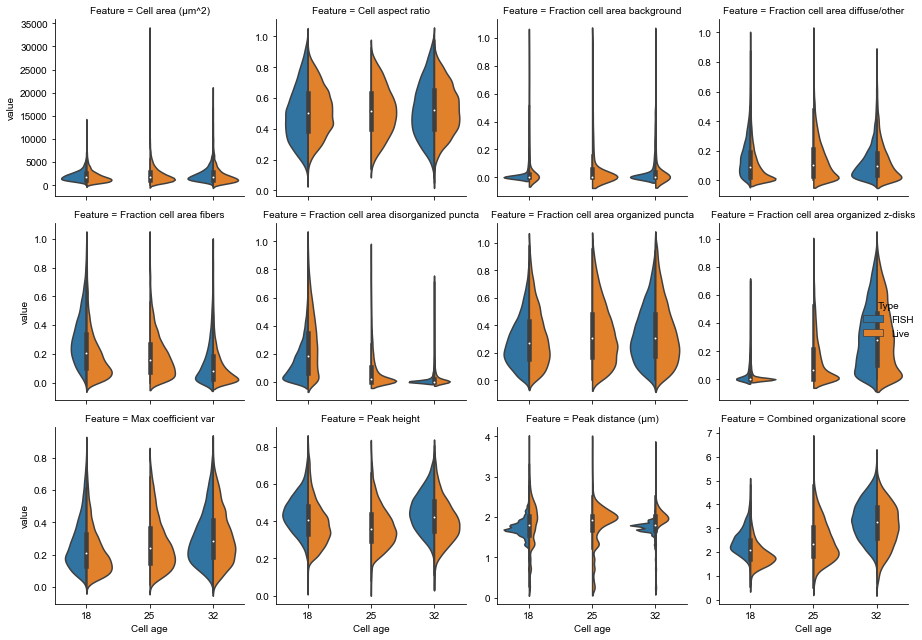

In [363]:
g = sns.catplot(
    data=df_feat_check.melt(
        id_vars=[c for c in df_feat_check if c not in BAR_PLOT_COLUMNS+["Combined organizational score"]],
        value_vars=BAR_PLOT_COLUMNS+["Combined organizational score"],
        var_name="Feature"
    ),
    col="Feature",
    col_wrap=4,
    x="Cell age",
    y='value',
    sharey=False,
    hue='Type',
    kind="violin",
    split=True,
    height=3,
)

plt.tight_layout()

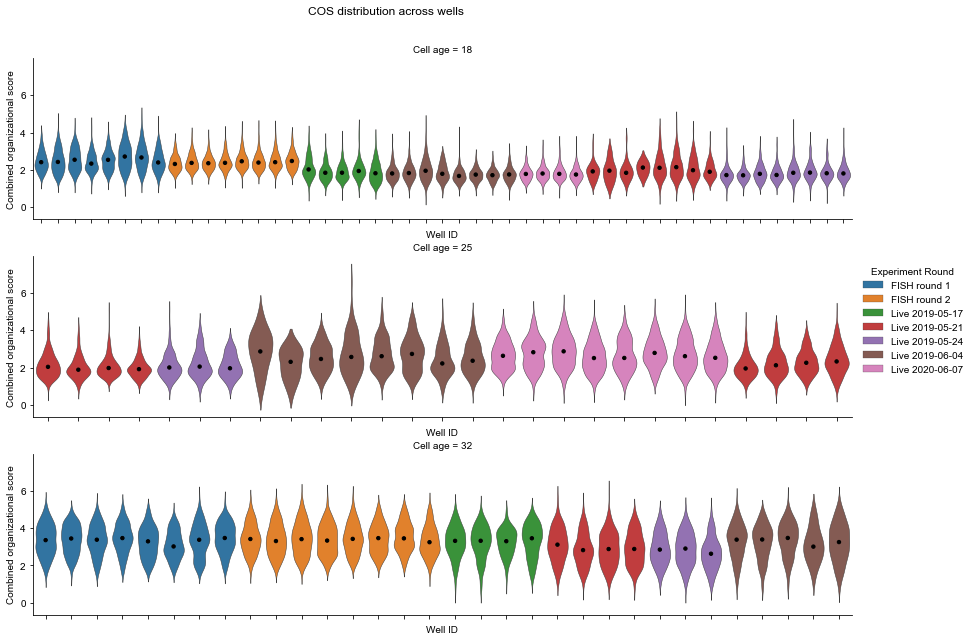

In [367]:
feature='Combined organizational score'

g = sns.catplot(
    data=df_feat_check.rename(columns={"ge_wellID":"Well ID"}),
    kind="violin",
    inner=None,
    linewidth=0.5,
    row="Cell age",
    x="Well ID",
    y=feature,
    hue="Experiment Round",
    errwidth=1,
    capsize=0.4,
    height=3,
    aspect=4,
    dodge=False,
    sharex=False
)

for i, age in enumerate(sorted(df_feat_check["Cell age"].unique())):
    sns.pointplot(
        ax=g.axes[i,0],
        data=df_feat_check[df_feat_check["Cell age"]==age].rename(columns={"ge_wellID":"Well ID"}),
        x="Well ID",
        y=feature,
        color='black',
        scale=0.5,
        estimator=np.median,
        ci=None,
        join=False,
    )

g.set(xticklabels=[])

plt.subplots_adjust(top=0.9)
g.fig.suptitle('COS distribution across wells', x="0.4");

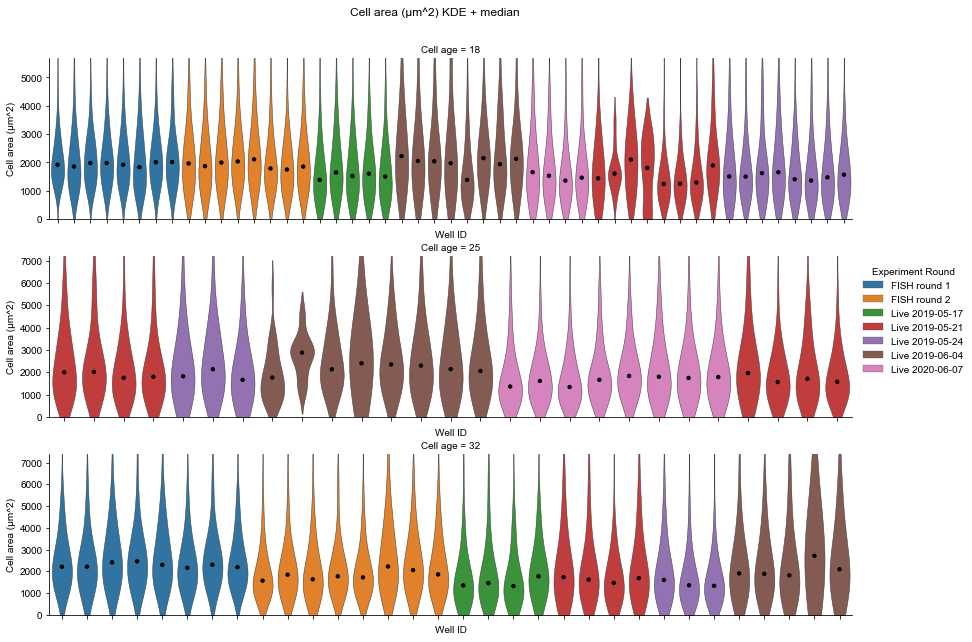

In [390]:
feature='Cell area (μm^2)'

g = sns.catplot(
    data=df_feat_check.rename(columns={"ge_wellID":"Well ID"}),
    kind="violin",
    linewidth=0.5,
    row="Cell age",
    row_order=sorted(df_feat_check["Cell age"].unique()),
    x="Well ID",
    y=feature,
    hue="Experiment Round",
    errwidth=1,
    capsize=0.4,
    height=3,
    aspect=4,
    dodge=False,
    sharex=False,
    sharey=False,
    inner=None,
    bw=0.5,
#     cut=0,
)


for i, (age,ax) in enumerate(zip(sorted(df_feat_check["Cell age"].unique()), g.axes.squeeze())):
    sns.pointplot(
        ax=ax,
        data=df_feat_check[df_feat_check["Cell age"]==age].rename(columns={"ge_wellID":"Well ID"}),
        x="Well ID",
        y=feature,
        color='black',
        scale=0.5,
        estimator=np.median,
        ci=None,
        join=False,
    )
    ax.set_ylim(0,np.quantile(df_feat_check[df_feat_check["Cell age"]==age][feature], 0.98))
    

g.set(
    xticklabels=[],
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle(f"{feature} KDE + median", x="0.45");

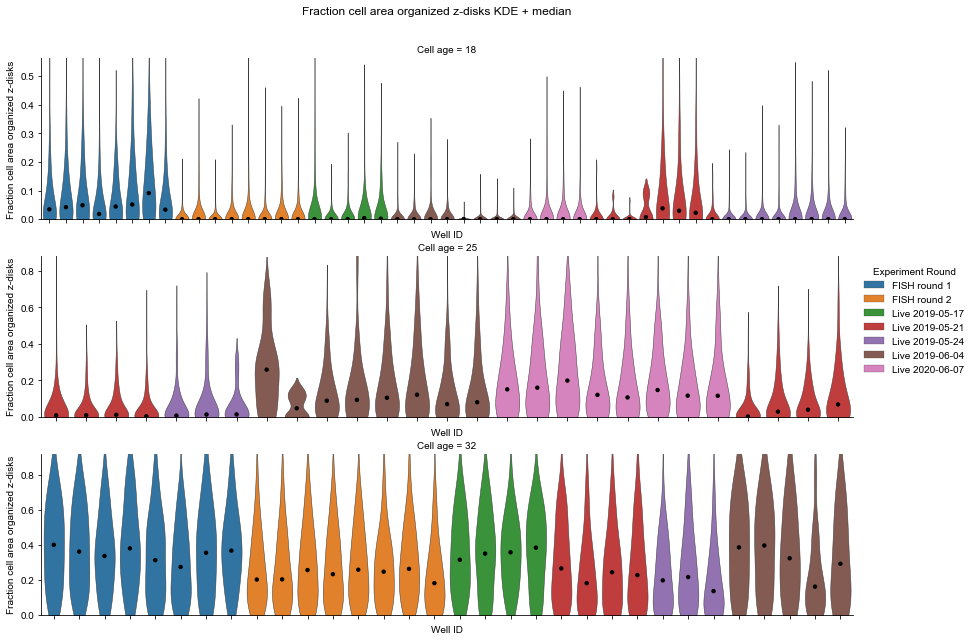

In [395]:
feature='Fraction cell area organized z-disks'

g = sns.catplot(
    data=df_feat_check.rename(columns={"ge_wellID":"Well ID"}),
    kind="violin",
    linewidth=0.5,
    row="Cell age",
    row_order=sorted(df_feat_check["Cell age"].unique()),
    x="Well ID",
    y=feature,
    hue="Experiment Round",
    errwidth=1,
    capsize=0.4,
    height=3,
    aspect=4,
    dodge=False,
    sharex=False,
    sharey=False,
    inner=None,
    bw=0.5,
#     cut=0,
)


for i, (age,ax) in enumerate(zip(sorted(df_feat_check["Cell age"].unique()), g.axes.squeeze())):
    sns.pointplot(
        ax=ax,
        data=df_feat_check[df_feat_check["Cell age"]==age].rename(columns={"ge_wellID":"Well ID"}),
        x="Well ID",
        y=feature,
        color='black',
        scale=0.5,
        estimator=np.median,
        ci=None,
        join=False,
    )
    ax.set_ylim(0,np.quantile(df_feat_check[df_feat_check["Cell age"]==age][feature], 0.999))
    

g.set(
    xticklabels=[],
)

plt.subplots_adjust(top=0.9)
g.fig.suptitle(f"{feature} KDE + median", x="0.45");

## check if plate + well_position = ge_wellID

In [408]:
N_unique_plate_well_combos = len(df_feat_check[["plate_name", "well_position"]].drop_duplicates().reset_index(drop=True))
N_unique_well_ids = len(df_feat_check[["ge_wellID"]].drop_duplicates().reset_index(drop=True))
assert N_unique_plate_well_combos == N_unique_well_ids

In [417]:
df_feat_check.groupby(["Cell age"])['Combined organizational score'].agg(['mean', 'std']).round(2)

,mean,std
Cell age,,
18,2.16,0.60
25,2.49,0.83
32,3.24,0.89


In [418]:
df_feat_check.groupby(["Cell age", 'Experiment Round'])['Combined organizational score'].agg(['mean', 'std']).round(2)

mean   std
Cell age Experiment Round            
18       FISH round 1      2.55  0.62
         FISH round 2      2.46  0.46
         Live 2019-05-17   2.00  0.55
         Live 2019-05-21   2.16  0.65
         Live 2019-05-24   1.86  0.46
         Live 2019-06-04   1.83  0.45
         Live 2020-06-07   1.83  0.39
25       Live 2019-05-21   2.17  0.66
         Live 2019-05-24   2.16  0.71
         Live 2019-06-04   2.59  0.89
         Live 2020-06-07   2.71  0.83
32       FISH round 1      3.35  0.82
         FISH round 2      3.43  0.83
         Live 2019-05-17   3.26  0.86
         Live 2019-05-21   2.95  0.91
         Live 2019-05-24   2.83  0.88
         Live 2019-06-04   3.29  0.97

In [419]:
pg.homoscedasticity(
    data=df_feat_check[
        df_feat_check["Cell age"]==18
    ].rename(
        columns={
            "Cell age":"Cell_age",
            'Combined organizational score':'Combined_organizational_score',
            "Experiment Round": "Experiment_Round", 
        }
    ).reset_index(),
    dv='Combined_organizational_score',
    group='Experiment_Round'
)

,W,pval,equal_var
levene,111.913132,2.198787e-138,False


In [420]:
pg.homoscedasticity(
    data=df_feat_check[
        df_feat_check["Cell age"]==25
    ].rename(
        columns={
            "Cell age":"Cell_age",
            'Combined organizational score':'Combined_organizational_score',
            "Experiment Round": "Experiment_Round", 
        }
    ).reset_index(),
    dv='Combined_organizational_score',
    group='Experiment_Round'
)

,W,pval,equal_var
levene,76.192689,1.912868e-48,False


In [421]:
pg.homoscedasticity(
    data=df_feat_check[
        df_feat_check["Cell age"]==32
    ].rename(
        columns={
            "Cell age":"Cell_age",
            'Combined organizational score':'Combined_organizational_score',
            "Experiment Round": "Experiment_Round", 
        }
    ).reset_index(),
    dv='Combined_organizational_score',
    group='Experiment_Round'
)

,W,pval,equal_var
levene,10.944047,1.603286e-10,False


## ANOVA

### first look at cell age

In [459]:
pd.concat(
    [
        pg.anova(
            data=df_feat_check.rename(
                columns={
                    "Cell age":"Cell_age",
                    'Combined organizational score':'Combined_organizational_score',
                    "Experiment Round": "Experiment_Round", 
                }
            ),
            dv='Combined_organizational_score',
            between=between
        ) for between in ["Type","Experiment_Round","Cell_age","ge_wellID"]
    ]
).reset_index(drop=True)

,Source,ddof1,ddof2,F,p-unc,np2
0,Type,1,29531,2439.629244,0.0,0.076308
1,Experiment_Round,6,29526,463.579444,0.0,0.086094
2,Cell_age,2,29530,5744.600619,0.0,0.280093
3,ge_wellID,107,29425,170.418239,0.0,0.382603


### Now look within each age at each other variable

In [473]:
dfs_anova = []
for between in ["Type","Experiment Round","ge_wellID"]:
    for age in sorted(df_feat_check["Cell age"].unique()):
        if len(df_feat_check[df_feat_check["Cell age"]==age][between].drop_duplicates()) > 1:
            df_anova = pg.anova(
                data=df_feat_check[df_feat_check["Cell age"]==age].rename(
                    columns={
                        "Cell age":"Cell_age",
                        'Combined organizational score':'Combined_organizational_score',
                        "Experiment Round": "Experiment_Round", 
                    }
                ),
                dv='Combined_organizational_score',
                between=between.replace(" ", "_"),
                detailed=True
            )
            df_anova["Cell age"] = age
            dfs_anova += [df_anova]
    
pd.concat(dfs_anova).reset_index(drop=True)

,Source,SS,DF,MS,F,p-unc,np2,Cell age
0,Type,1202.799841,1,1202.799841,4470.366750,0.000000e+00,0.244786,18
1,Within,3710.884661,13792,0.269061,NaN,NaN,NaN,18
2,Type,225.574274,1,225.574274,293.698176,7.962959e-65,0.031139,32
3,Within,7018.421912,9138,0.768048,NaN,NaN,NaN,32
4,Experiment_Round,1309.454341,6,218.242390,834.826772,0.000000e+00,0.266491,18
5,Within,3604.230161,13787,0.261422,NaN,NaN,NaN,18
6,Experiment_Round,404.417941,3,134.805980,215.799928,1.535282e-133,0.089390,25
7,Within,4119.767086,6595,0.624680,NaN,NaN,NaN,25
8,Experiment_Round,412.386402,5,82.477280,110.273787,1.768549e-113,0.056928,32
9,Within,6831.609784,9134,0.747932,NaN,NaN,NaN,32


### Day 18 across wells

In [475]:
pg.anova(
    data=df_feat_check[df_feat_check["Cell age"]==18].rename(
        columns={
            'Combined organizational score':'Combined_organizational_score'
        }
    ),
    dv='Combined_organizational_score',
    between=[
        "ge_wellID",
    ],
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,ge_wellID,1402.177739,48,29.212036,114.343917,0.0,0.285362
1,Within,3511.506763,13745,0.255475,NaN,NaN,NaN


### Day 18 across wells within round 1

In [480]:
pg.anova(
    data=df_feat_check[(df_feat_check["Cell age"]==18) & (df_feat_check["Experiment Round"]=="FISH round 1")].rename(
        columns={
            "Cell age":"Cell_age",
            'Combined organizational score':'Combined_organizational_score',
            "Experiment Round": "Experiment_Round", 
        }
    ),
    dv='Combined_organizational_score',
    between=[
        "ge_wellID",
    ],
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,ge_wellID,31.021936,7,4.431705,11.889272,5.300464e-15,0.030184
1,Within,996.728770,2674,0.372748,NaN,NaN,NaN


### Day 18 across wells round 2

In [481]:
pg.anova(
    data=df_feat_check[(df_feat_check["Cell age"]==18) & (df_feat_check["Experiment Round"]=="FISH round 2")].rename(
        columns={
            "Cell age":"Cell_age",
            'Combined organizational score':'Combined_organizational_score',
            "Experiment Round": "Experiment_Round", 
        }
    ),
    dv='Combined_organizational_score',
    between=[
        "ge_wellID",
    ],
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,ge_wellID,7.746363,7,1.106623,5.220886,0.000006,0.011313
1,Within,677.002872,3194,0.211961,NaN,NaN,NaN


### Day 32 across plates

In [483]:
pg.anova(
    data=df_feat_check[df_feat_check["Cell age"]==32].rename(
        columns={
            'Combined organizational score':'Combined_organizational_score'
        }
    ),
    dv='Combined_organizational_score',
    between=[
        "plate_name",
    ],
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,plate_name,413.335069,6,68.889178,92.108927,1.041847e-112,0.057059
1,Within,6830.661117,9133,0.747910,NaN,NaN,NaN


### Day 32 across wells

In [484]:
pg.anova(
    data=df_feat_check[df_feat_check["Cell age"]==32].rename(
        columns={
            'Combined organizational score':'Combined_organizational_score'
        }
    ),
    dv='Combined_organizational_score',
    between=[
        "ge_wellID",
    ],
    detailed=True
)

,Source,SS,DF,MS,F,p-unc,np2
0,ge_wellID,479.383967,31,15.463999,20.821016,1.091692e-111,0.066177
1,Within,6764.612219,9108,0.742711,NaN,NaN,NaN


## check COS predictions on new annotations

In [490]:
[c for c in df_live.columns if "score" in c]

['MH_score', 'KG_score', 'Combined organizational score']

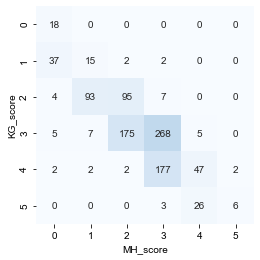

In [496]:
from sklearn.metrics import confusion_matrix

df_expert = df_live.dropna(subset=['MH_score', 'KG_score'])
conf_mat = confusion_matrix(df_expert['KG_score'], df_expert['MH_score'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot = sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1000,
    cbar=False,
)

conf_mat_plot.set(
    xlabel='MH_score',
    ylabel='KG_score'
);

# # save png and svg
# if SAVE:
#     plt.savefig(save_dir_pngs/'fig_3supp_expert_annotations_confmat.png', dpi=100, bbox_inches = "tight")
#     plt.savefig(save_dir_svgs/'fig_3supp_expert_annotations_confmat.svg', format="svg", bbox_inches = "tight")

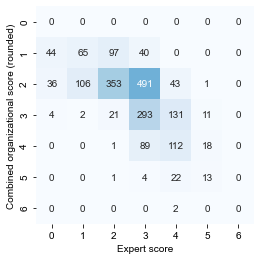

In [519]:
df_expert_melt = df_expert[['MH_score', 'KG_score', 'Combined organizational score']].melt(
    value_vars=['MH_score', 'KG_score'],
    id_vars='Combined organizational score',
    var_name="Expert annotator",
    value_name="Expert score"
)
df_expert_melt["Expert annotator"] = df_expert_melt["Expert annotator"].apply(lambda x: x.split("_")[0])
df_expert_melt['Combined organizational score (rounded)'] = np.round(df_expert_melt['Combined organizational score'])

conf_mat = confusion_matrix(df_expert_melt['Combined organizational score (rounded)'], df_expert_melt['Expert score'])

dims = (4, 4)
fig, ax = plt.subplots(figsize=dims)
conf_mat_plot = sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    square=True,
    cmap="Blues",
    vmin=0,
    vmax=1000,
    cbar=False,
)

conf_mat_plot.set(
    xlabel='Expert score',
    ylabel='Combined organizational score (rounded)'
);


In [521]:
spearmanr(df_expert['MH_score'], df_expert['KG_score'])

SpearmanrResult(correlation=0.7845032701140823, pvalue=2.520336038004067e-209)

In [522]:
spearmanr(df_expert['MH_score'], df_expert['Combined organizational score'])

SpearmanrResult(correlation=0.7244208768840845, pvalue=2.0407323000527527e-163)

In [523]:
spearmanr(df_expert['KG_score'], df_expert['Combined organizational score'])

SpearmanrResult(correlation=0.7222056083674946, pvalue=5.856465493863292e-162)

In [525]:
spearmanr(df_expert_melt['Expert score'], df_expert_melt['Combined organizational score'])

SpearmanrResult(correlation=0.6953326733749533, pvalue=5.98269249768621e-289)